In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import scipy.stats as stats
import tabulate as tb

In [232]:
RES_PATH = './res/'
ROC_PREFIX='roc'
SUMM_PREFIX='res'

In [233]:
summary_files = [os.path.join(RES_PATH, f) for f in os.listdir(RES_PATH) if f.startswith(SUMM_PREFIX) and f.endswith('.csv')]
print("Summary files found:", summary_files)

df_all = pd.DataFrame()
for file in summary_files:
    try:
        temp_df = pd.read_csv(file)
        df_all = pd.concat([df_all, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        
df_all['precision'] = df_all['TP'] / (df_all['TP'] + df_all['FP'])
df_all['recall'] = df_all['TP'] / (df_all['TP'] + df_all['FN'])
df_all['f1_score'] = 2 * (df_all['precision'] * df_all['recall']) / (df_all['precision'] + df_all['recall'])
df_all = df_all.rename(columns={
    'model_name': 'model',
})
        
print(tb.tabulate(df_all.head(), headers='keys', tablefmt='psql'))

Summary files found: ['./res/res_sex_efficientnetv2.csv']
+----+-------+----------------+---------------------+--------------+----------------------+-------------+---------------------+---------------------------+---------------------------+---------------+--------------+------------+------+------+------+------+--------------------+--------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+-------------+----------+------------+
|    |   rep | model          | feature_split_col   |   train_size | train_ratio_detail   |   test_size | test_ratio_detail   | train_ratio_rel           | test_ratio_rel            | train_ratio   | test_ratio   |   accuracy |   TN |   FP |   FN |   TP |   fairness_tp

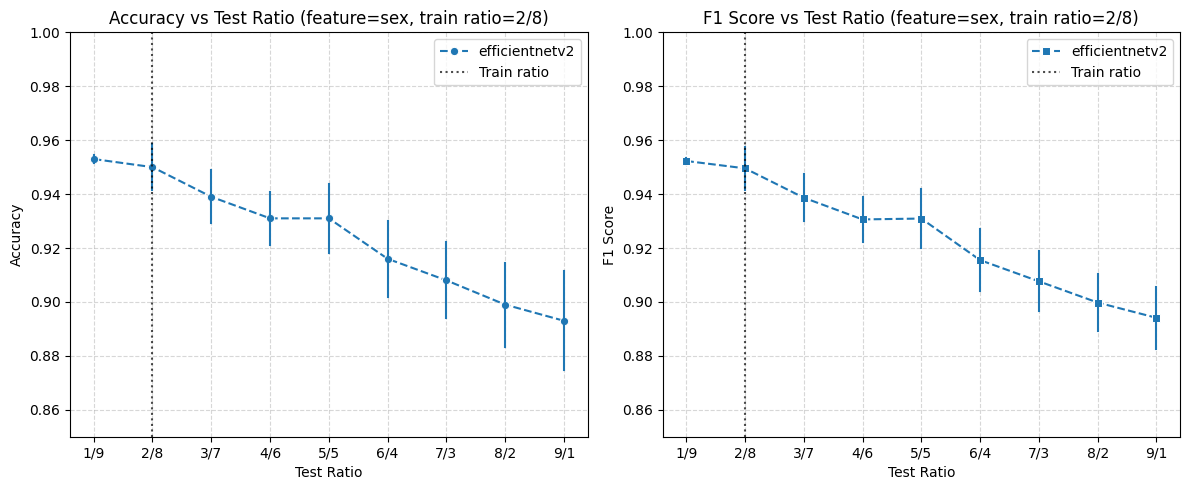

In [234]:
def handle_base_metrics(df_org, feature, train_ratio):
    df = df_org[(df_org['train_ratio'] == train_ratio) & (df_org['feature_split_col'] == feature)].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    df['test_ratio'] = pd.Categorical(
        df['test_ratio'], 
        categories=sorted(df['test_ratio'].unique(), key=lambda x: eval(x.replace('/', ','))),
        ordered=True
    )
    
    # Accuracy
    acc_plot = sns.lineplot(
        data=df,
        x='test_ratio',
        y='accuracy',
        hue='model',
        marker='o',
        linestyle='--',
        err_style='bars',
        errorbar='sd',
        ax=axes[0]
    )
    axes[0].set_title(f'Accuracy vs Test Ratio (feature={feature}, train ratio={train_ratio})')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Test Ratio')
    axes[0].set_ylim(0.85, 1.0)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # F1
    f1_plot = sns.lineplot(
        data=df,
        x='test_ratio',
        y='f1_score',
        hue='model',
        marker='s',
        linestyle='--',
        err_style='bars',
        errorbar='sd',
        ax=axes[1]
    )
    axes[1].set_title(f'F1 Score vs Test Ratio (feature={feature}, train ratio={train_ratio})')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_xlabel('Test Ratio')
    axes[1].set_ylim(0.85, 1.0)
    axes[1].grid(True, linestyle='--', alpha=0.5)

                
    # 🔷 Add vertical line
    if train_ratio in df['test_ratio'].unique():
        axes[0].axvline(x=train_ratio, color='black', linestyle=':', alpha=0.7, label='Train ratio')
        axes[1].axvline(x=train_ratio, color='black', linestyle=':', alpha=0.7, label='Train ratio')
        axes[0].legend(title=None)
        axes[1].legend(title=None)
    

    plt.tight_layout()
    plt.show()

    
handle_base_metrics(df_all, 'sex', '2/8')